In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score,confusion_matrix
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [32]:
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.n_classes_ = len(set(y))
        self.n_features_ = X.shape[1]
        self.tree = self._grow_tree(X, y)

    def predict(self, X):
        return [self._predict(inputs) for inputs in X]

    def _gini(self, y):
        m = len(y)
        return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(
            gini=self._gini(y),
            num_samples=len(y),
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def _best_split(self, X, y):
        m, n = X.shape
        if m <= 1:
            return None, None

        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((num / m) ** 2 for num in num_parent)
        best_idx, best_thr = None, None

        for idx in range(n):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.n_classes_))
                gini_right = 1.0 - sum((num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_))
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        return best_idx, best_thr

    def _predict(self, inputs):
        node = self.tree
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class




In [37]:
data = pd.read_csv("Breast_cancer_data.csv")
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


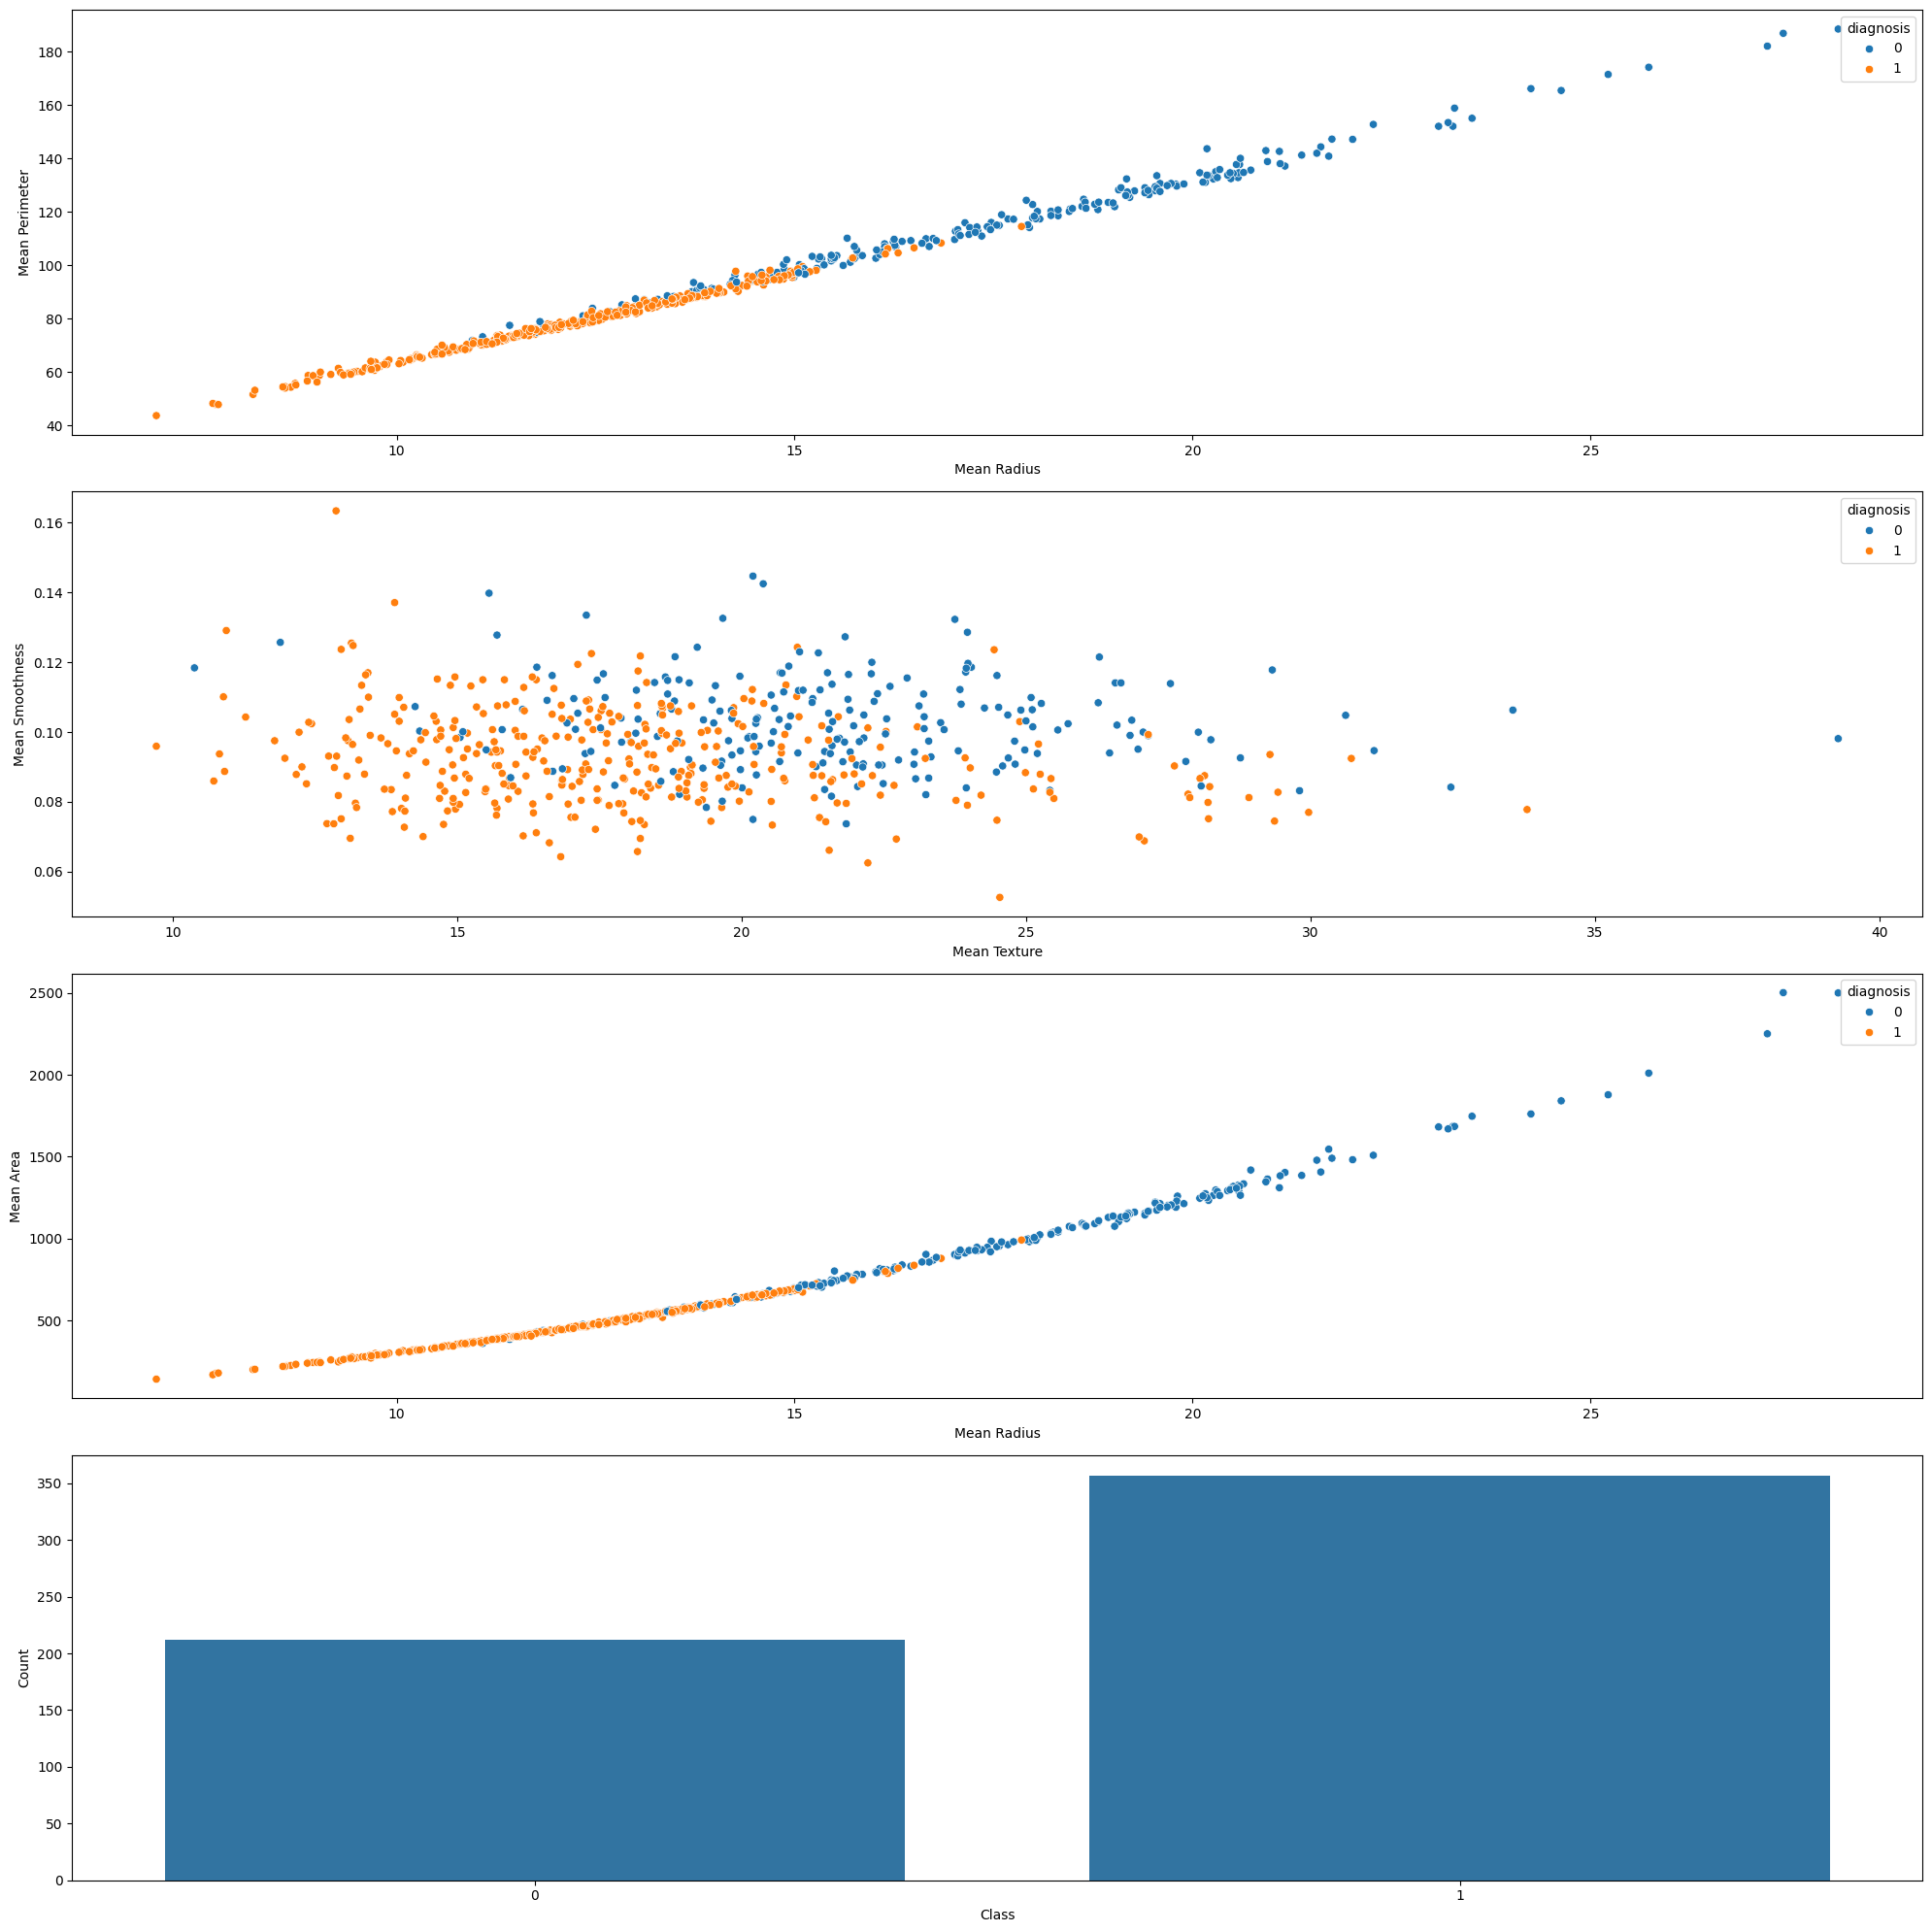

In [34]:
target_counts = data['diagnosis'].value_counts()

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(4,1,1)  # Correct way to add a subplot
sns.scatterplot(x=data['mean_radius'], y=data['mean_perimeter'], hue=data['diagnosis'], ax=ax1)
ax1.set_xlabel("Mean Radius")
ax1.set_ylabel("Mean Perimeter")

ax2 = fig.add_subplot(4,1,2)
sns.scatterplot(x=data['mean_texture'],y=data['mean_smoothness'],hue=data['diagnosis'])
ax2.set_xlabel("Mean Texture")
ax2.set_ylabel("Mean Smoothness")

ax3 = fig.add_subplot(4,1,3)
sns.scatterplot(x=data['mean_radius'],y=data['mean_area'],hue=data['diagnosis'])
ax3.set_xlabel("Mean Radius")
ax3.set_ylabel("Mean Area")

ax4 = fig.add_subplot(4,1,4)
sns.barplot(x=target_counts.index,y=target_counts.values)
ax4.set_xlabel("Class")
ax4.set_ylabel("Count")

fig.tight_layout()
plt.show()  


In [35]:
data.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


In [ ]:
scaler = StandardScaler()

X = data.drop(['diagnosis'],axis=1)
X = scaler.fit_transform(X)

y = data['diagnosis'].apply(lambda x: 1 if x == 1 else 0).values


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [52]:
model = DecisionTree(max_depth=5)
model.fit(X,y)
predictions = model.predict(X)
print(accuracy_score(y,predictions))

0.9630931458699473
